# 1. EDA sobre Ofertas Relámpago en Mercadolibre

- Objetivo: El objetivo de este ejercicio es realizar un Análisis Exploratorio de Datos (EDA) sobre el archivo ofertas_relampago.csv, que contiene información sobre las ofertas relámpago en Mercado Libre. A través de este análisis se busca identificar patrones, tendencias e insights relevantes acerca del comportamiento, duración y desempeño de este tipo de ofertas, facilitando una mejor comprensión sobre su naturaleza.


In [40]:
import pandas as pd
import warnings

warnings.filterwarnings("ignore")

df = pd.read_csv('../data/ofertas_relampago.csv')
display(df.head())

print("\n" + "="*50 + "\n")

print("Información general del DataFrame:")
df.info()


,OFFER_START_DATE,OFFER_START_DTTM,OFFER_FINISH_DTTM,OFFER_TYPE,INVOLVED_STOCK,REMAINING_STOCK_AFTER_END,SOLD_AMOUNT,SOLD_QUANTITY,ORIGIN,SHIPPING_PAYMENT_TYPE,DOM_DOMAIN_AGG1,VERTICAL,DOMAIN_ID
0,2021-06-22,2021-06-22 16:00:00+00:00,2021-06-22 23:02:43+00:00,lightning_deal,4,-2,4.72,6.0,A,none,PETS FOOD,CPG,MLM-BIRD_FOODS
1,2021-06-22,2021-06-22 13:00:00+00:00,2021-06-22 19:00:02+00:00,lightning_deal,5,5,NaN,NaN,NaN,free_shipping,PET PRODUCTS,OTHERS,MLM-ANIMAL_AND_PET_PRODUCTS
2,2021-06-22,2021-06-22 07:00:00+00:00,2021-06-22 13:00:01+00:00,lightning_deal,15,12,10.73,3.0,NaN,none,COMPUTERS,CE,MLM-SPEAKERS
3,2021-06-22,2021-06-22 19:00:00+00:00,2021-06-23 01:36:12+00:00,lightning_deal,15,13,7.03,2.0,NaN,none,COMPUTERS,CE,MLM-HEADPHONES
4,2021-06-22,2021-06-22 13:00:00+00:00,2021-06-22 15:48:12+00:00,lightning_deal,15,0,39.65,15.0,NaN,none,COMPUTERS,CE,MLM-HEADPHONES




Información general del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48746 entries, 0 to 48745
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   OFFER_START_DATE           48746 non-null  object 
 1   OFFER_START_DTTM           48746 non-null  object 
 2   OFFER_FINISH_DTTM          48746 non-null  object 
 3   OFFER_TYPE                 48746 non-null  object 
 4   INVOLVED_STOCK             48746 non-null  int64  
 5   REMAINING_STOCK_AFTER_END  48746 non-null  int64  
 6   SOLD_AMOUNT                24579 non-null  float64
 7   SOLD_QUANTITY              24579 non-null  float64
 8   ORIGIN                     11316 non-null  object 
 9   SHIPPING_PAYMENT_TYPE      48746 non-null  object 
 10  DOM_DOMAIN_AGG1            48746 non-null  object 
 11  VERTICAL                   48746 non-null  object 
 12  DOMAIN_ID                  48746 non-null  object 
dtypes: float6

## Calidad del dato

--- CONCLUSIÓN: Inconsistencia en el Registro de Stock ---
Se ha confirmado una inconsistencia en el 7.35% de las ofertas (3,583 de 48,746).
La fórmula INVOLVED_STOCK - SOLD_QUANTITY no siempre coincide con REMAINING_STOCK_AFTER_END.

El siguiente gráfico visualiza esta discrepancia:


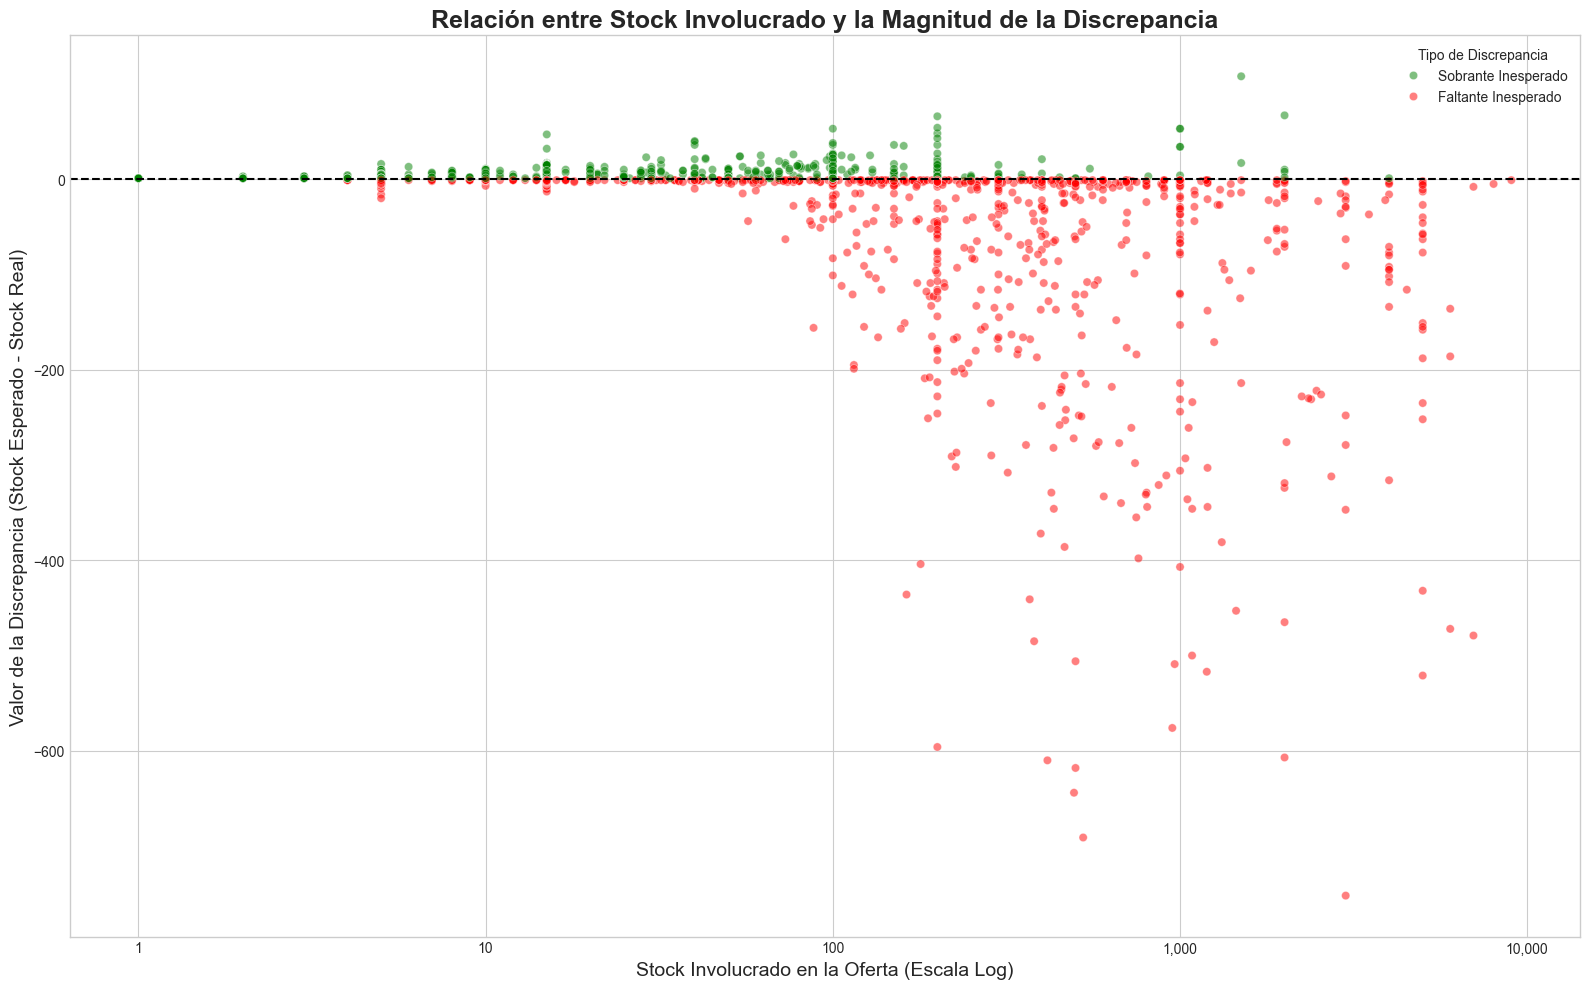

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df['OFFER_START_DTTM'] = pd.to_datetime(df['OFFER_START_DTTM'])
df['OFFER_FINISH_DTTM'] = pd.to_datetime(df['OFFER_FINISH_DTTM'])
df['SOLD_AMOUNT'] = df['SOLD_AMOUNT'].fillna(0)
df['SOLD_QUANTITY'] = df['SOLD_QUANTITY'].fillna(0)
df['OFFER_DURATION_HOURS'] = (df['OFFER_FINISH_DTTM'] - df['OFFER_START_DTTM']).dt.total_seconds() / 3600
df['SOLD_QUANTITY_CALCULATED'] = df['INVOLVED_STOCK'] - df['REMAINING_STOCK_AFTER_END']

# --- 2. Cálculo y Aislamiento de la Discrepancia ---
# Se calcula el stock restante esperado y la diferencia con el valor real.
df['EXPECTED_REMAINING_STOCK'] = df['INVOLVED_STOCK'] - df['SOLD_QUANTITY']
df['STOCK_DISCREPANCY'] = df['EXPECTED_REMAINING_STOCK'] - df['REMAINING_STOCK_AFTER_END']

# Se aíslan las filas donde la fórmula no cuadra.
inconsistent_stock = df[df['STOCK_DISCREPANCY'] != 0].copy()

print("--- CONCLUSIÓN: Inconsistencia en el Registro de Stock ---")
inconsistent_rows_count = len(inconsistent_stock)
total_rows = len(df)
inconsistency_percentage = (inconsistent_rows_count / total_rows) * 100
print(f"Se ha confirmado una inconsistencia en el {inconsistency_percentage:.2f}% de las ofertas ({inconsistent_rows_count:,} de {total_rows:,}).")
print("La fórmula INVOLVED_STOCK - SOLD_QUANTITY no siempre coincide con REMAINING_STOCK_AFTER_END.")
print("\nEl siguiente gráfico visualiza esta discrepancia:")

# --- Visualización Enfocada: Gráfico de Dispersión ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(16, 10))

# Gráfico de dispersión para analizar la relación entre el stock y el error.
sns.scatterplot(
    data=inconsistent_stock,
    x='INVOLVED_STOCK',
    y='STOCK_DISCREPANCY',
    ax=ax,
    alpha=0.5,
    hue=np.where(inconsistent_stock['STOCK_DISCREPANCY'] > 0, 'Sobrante Inesperado', 'Faltante Inesperado'),
    palette={'Sobrante Inesperado': 'green', 'Faltante Inesperado': 'red'}
)

ax.set_title('Relación entre Stock Involucrado y la Magnitud de la Discrepancia', fontsize=18, weight='bold')
ax.set_xlabel('Stock Involucrado en la Oferta (Escala Log)', fontsize=14)
ax.set_ylabel('Valor de la Discrepancia (Stock Esperado - Stock Real)', fontsize=14)
ax.axhline(0, color='black', linestyle='--', linewidth=1.5)
ax.set_xscale('log')
ax.legend(title='Tipo de Discrepancia')
ax.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))

plt.tight_layout()
plt.show()


Dada la anterior gráfica, es notable ver que existe una inconsistencia en la calidad del dato de REMAINING_STOCK_AFTER_END, pues no coincide en todos los casos con la resta de df'INVOLVED_STOCK' y 'REMAINING_STOCK_AFTER_END'. Dado lo anterior, tomé la decisión de continuar con el valor calculado y no con el que se encuentra de en la columna, ya que aproximadamente el 7% tiene discrepancia. Es un problema de la calidad del dato. De ahora en adelante, decidí continuar con la cantidad calculada en vez de usar la métrica cuestionada.

## Entendimiento de la columna "SOLD_AMOUNT"

### Correlación de "SOLD_AMOUNT" con "SOLD QUANTITY"

Dado que no es explícita la unidad que representa "SOLD_AMOUNT", quiero validar la hipótesis de que esa columna se trata de una unidad monetaria. El primer paso es entender is existe una correlación entre unidades vendidas y "SOLD_AMOUNT"

In [41]:
import pandas as pd

df['SOLD_QUANTITY'] = pd.to_numeric(df['SOLD_QUANTITY'], errors='coerce')
df['SOLD_AMOUNT'] = pd.to_numeric(df['SOLD_AMOUNT'], errors='coerce')

df['SOLD_QUANTITY'] = df['SOLD_QUANTITY'].fillna(0)
df['SOLD_AMOUNT'] = df['SOLD_AMOUNT'].fillna(0)

correlation_matrix = df[['SOLD_QUANTITY', 'SOLD_AMOUNT']].corr()

print("Matriz de Correlación:")
print(correlation_matrix)

Matriz de Correlación:
               SOLD_QUANTITY  SOLD_AMOUNT
SOLD_QUANTITY       1.000000     0.718134
SOLD_AMOUNT         0.718134     1.000000


La anterior matriz de correlación muestra que existe una correlación fuerte entre la variable SOLD_QUANTITY y SOLD_AMOUNT, donde SOLD_AMOUNT pareciera referirse al precio. Sin mayor información es dificil saberlo pero si se ve una mayor relación SOLD_AMOUNT/SOLD_QUANTITY como se muestra en el siguiente gráfico. Cabe mencionar que solo es un supuesto de que esta columna corresponda a una unidad monetaria.

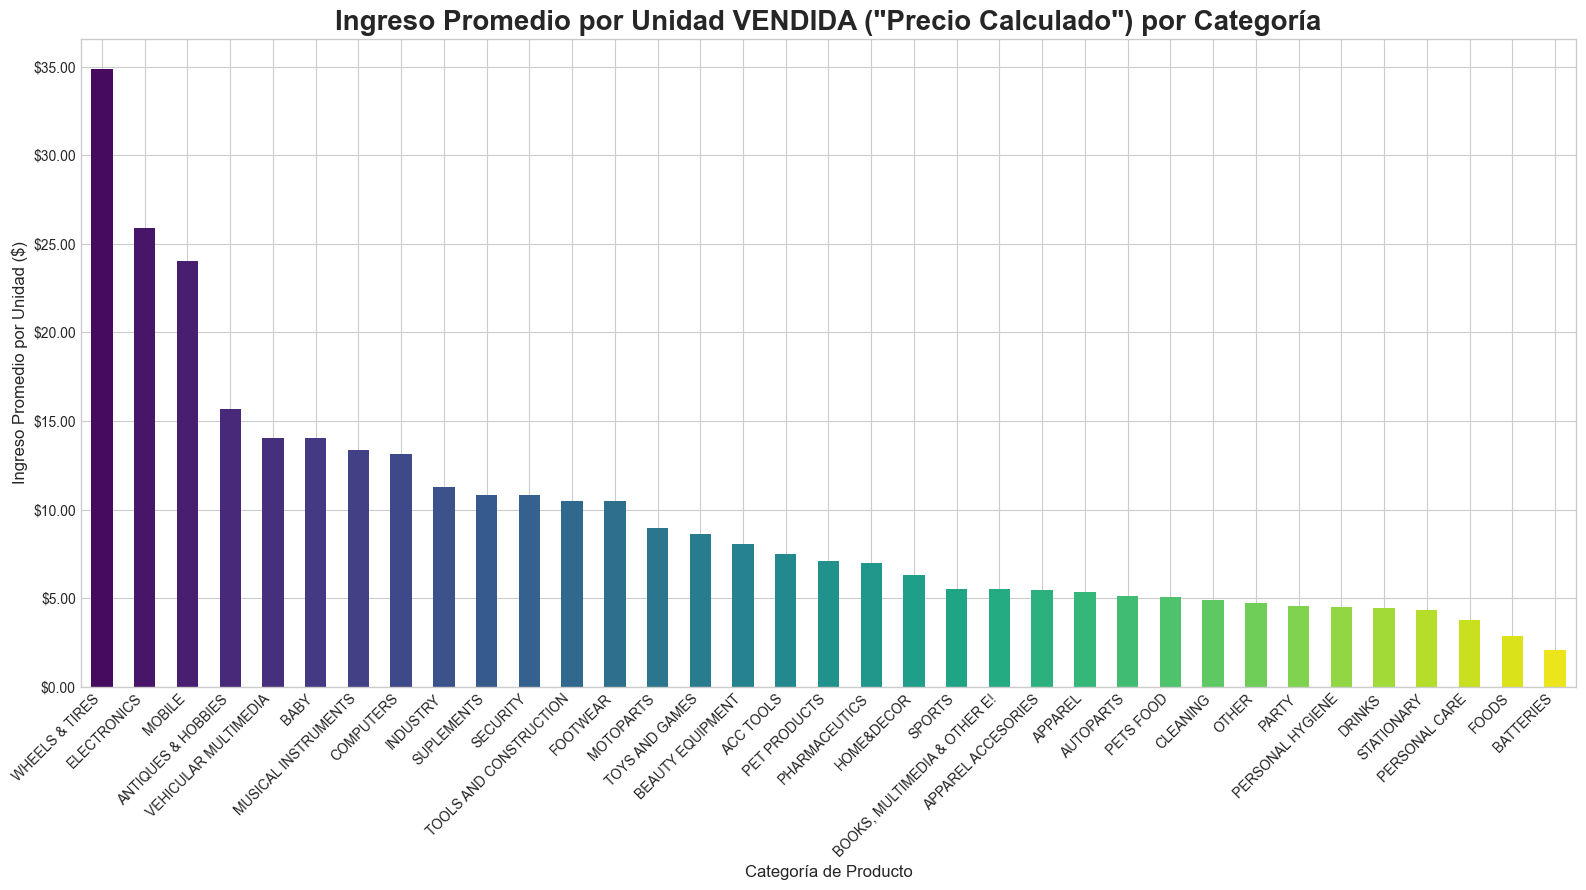

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df_sold = df[df['SOLD_QUANTITY'] > 0].copy()

df_sold['avg_revenue_per_unit'] = df_sold['SOLD_AMOUNT'] / df_sold['SOLD_QUANTITY']

avg_revenue_by_category = df_sold.groupby('DOM_DOMAIN_AGG1')['avg_revenue_per_unit'].mean().sort_values(ascending=False)

plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(16, 9))

avg_revenue_by_category.plot(kind='bar', ax=ax, color=sns.color_palette('viridis', len(avg_revenue_by_category)))

ax.set_title('Ingreso Promedio por Unidad VENDIDA ("Precio Calculado") por Categoría', fontsize=20, weight='bold')
ax.set_xlabel('Categoría de Producto', fontsize=12)
ax.set_ylabel('Ingreso Promedio por Unidad ($)', fontsize=12)

ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, p: f"${x:,.2f}"))
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()


La anterior gráfica refuerza esa hipótesis, pues allí se se refleja el valor promedio del cociente entre 'SOLD_AMOUNT' y 'SOLD_QUANTITY' por categoría. 
Por ejemplo, el ticket promedio de "Wheels & Tires" es mucho mayor que el ticket para "Drinks" o "Personal Care", lo que tiene mucho sentido.

## Relación Ingresos Totales vs. Cantidad de Ítems Vendidos por Categoría 

Asumiendo como cierta la anterior hipótesis, es de interés entender la cantidad de ítems vendidos y el revenue total por cada una de las categorías

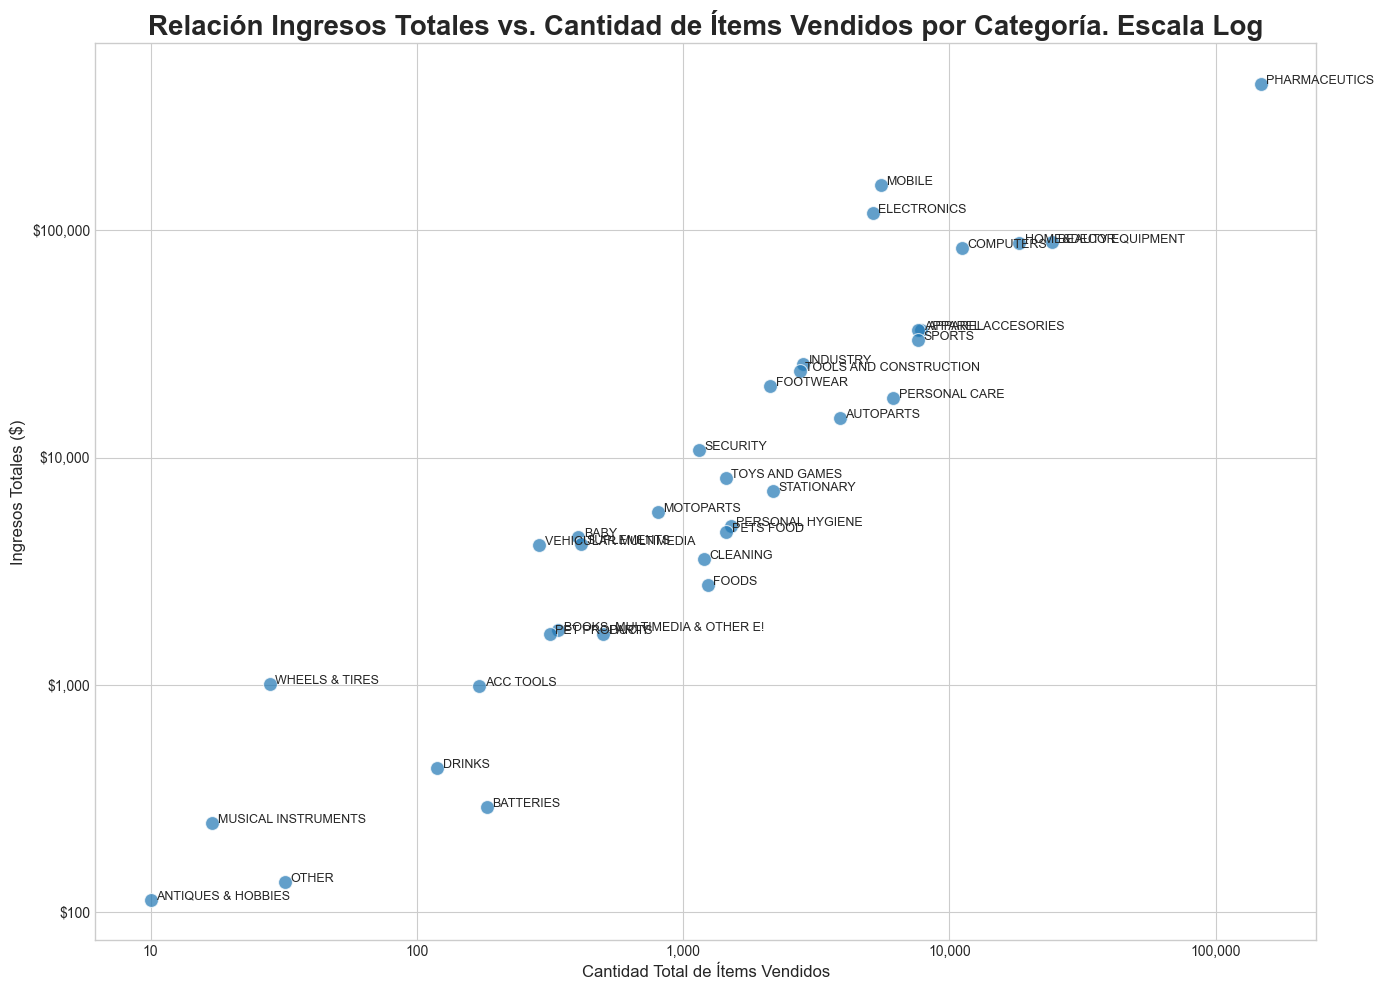

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


category_performance = df_sold.groupby('DOM_DOMAIN_AGG1').agg(
    total_items_sold=('SOLD_QUANTITY', 'sum'),
    total_revenue=('SOLD_AMOUNT', 'sum')
).reset_index()

plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(14, 10))

sns.scatterplot(
    data=category_performance,
    x='total_items_sold',
    y='total_revenue',
    ax=ax,
    s=100, 
    alpha=0.7
)

# --- Anotación de los Puntos ---
for i, row in category_performance.iterrows():
    ax.text(
        row['total_items_sold'] * 1.05, 
        row['total_revenue'],
        row['DOM_DOMAIN_AGG1'],
        fontsize=9
    )

# --- 5. Mejoras Visuales ---
ax.set_title('Relación Ingresos Totales vs. Cantidad de Ítems Vendidos por Categoría. Escala Log', fontsize=20, weight='bold')
ax.set_xlabel('Cantidad Total de Ítems Vendidos', fontsize=12)
ax.set_ylabel('Ingresos Totales ($)', fontsize=12)

ax.set_xscale('log')
ax.set_yscale('log')

ax.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, p: f"${x:,.0f}"))

plt.tight_layout()
plt.show()


En la anterior gráfica se puede ver la relación entre los "ingresos" totales y y la cantidad de ítems vendidos en una escala logarítmica. Allí se puede notar que la categoría "PHARMACEUTICS" tiene la mayor cantidad de unidades vendidas y el mayor revenue a la vez. Dado el rango de fechas del dataset, es notable que corresponde al fenómeno vivido en la pandemia.

--- Análisis de Rendimiento por Categoría de Producto (Ordenado por % de Ingresos) ---


,sales_participation_pct,revenue_participation_pct,total_sold_quantity,total_revenue
DOM_DOMAIN_AGG1,,,,
PHARMACEUTICS,43.867759,34.974935,94993,440216.74
MOBILE,2.966603,12.631828,6424,158992.21
ELECTRONICS,2.879322,9.522319,6235,119853.95
BEAUTY EQUIPMENT,10.781643,7.057506,23347,88830.25
HOME&DECOR,8.409838,6.972606,18211,87761.65
COMPUTERS,6.081443,6.669120,13169,83941.78
APPAREL,3.335581,2.905455,7223,36569.90
APPAREL ACCESORIES,3.310644,2.905116,7169,36565.63
SPORTS,3.515683,2.631259,7613,33118.70


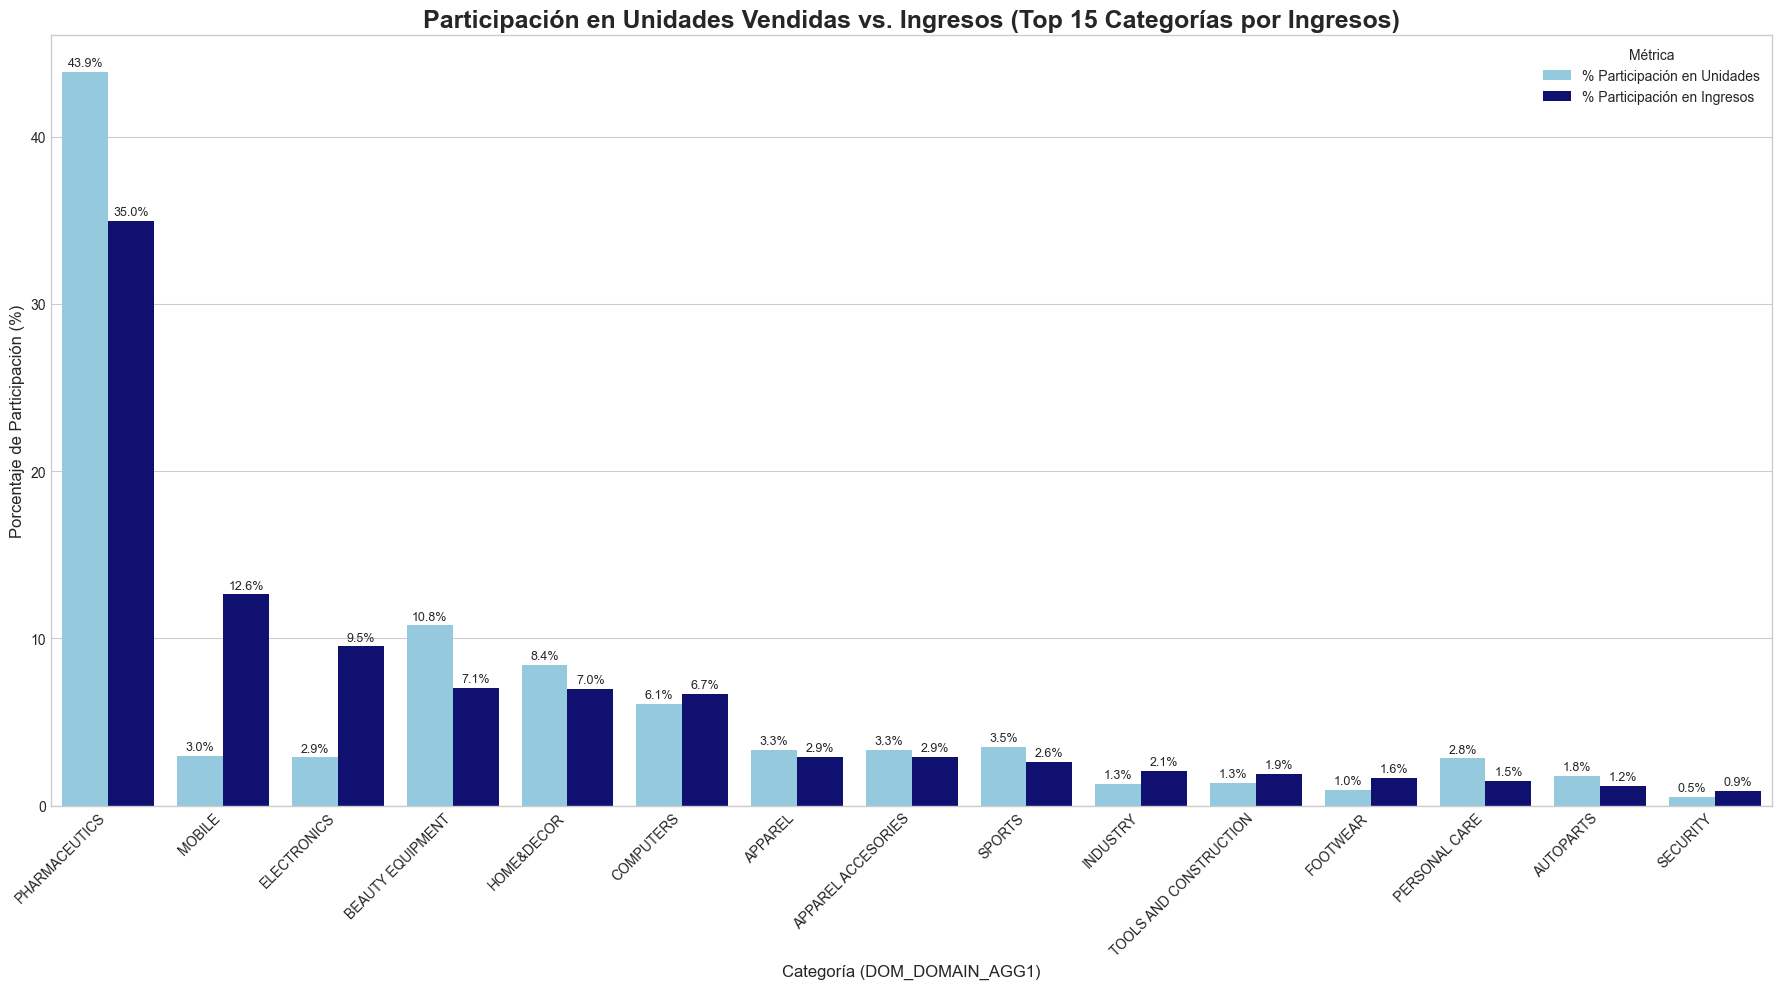

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Agrupación por Categoría y Cálculo de Métricas ---
agg_by_category = df.groupby('DOM_DOMAIN_AGG1').agg(
    total_sold_quantity=('SOLD_QUANTITY_CALCULATED', 'sum'),
    total_revenue=('SOLD_AMOUNT', 'sum'), 
    avg_duration_hours=('OFFER_DURATION_HOURS', 'mean'),
    offer_count=('OFFER_TYPE', 'count')
)

# --- Cálculo de la Participación en Ventas y en Ingresos ---
total_overall_sales = df['SOLD_QUANTITY_CALCULATED'].sum()
total_overall_revenue = df['SOLD_AMOUNT'].sum() 

# Calculamos los porcentajes para ambas métricas
agg_by_category['sales_participation_pct'] = (agg_by_category['total_sold_quantity'] / total_overall_sales) * 100
agg_by_category['revenue_participation_pct'] = (agg_by_category['total_revenue'] / total_overall_revenue) * 100

agg_by_category = agg_by_category.sort_values(by='revenue_participation_pct', ascending=False)

# --- Mostrar los Resultados en una Tabla ---
print("--- Análisis de Rendimiento por Categoría de Producto (Ordenado por % de Ingresos) ---")
display(agg_by_category[['sales_participation_pct', 'revenue_participation_pct', 'total_sold_quantity', 'total_revenue']].head(15))


# --- Preparación de Datos para Gráfico Agrupado ---
plot_data = agg_by_category.head(15)[['sales_participation_pct', 'revenue_participation_pct']]

plot_data_melted = plot_data.reset_index().melt(
    id_vars='DOM_DOMAIN_AGG1',
    value_vars=['sales_participation_pct', 'revenue_participation_pct'],
    var_name='Metric',
    value_name='Percentage'
)
plot_data_melted['Metric'] = plot_data_melted['Metric'].map({
    'sales_participation_pct': '% Participación en Unidades',
    'revenue_participation_pct': '% Participación en Ingresos'
})

plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(18, 10))

sns.barplot(
    data=plot_data_melted,
    x='DOM_DOMAIN_AGG1',
    y='Percentage',
    hue='Metric', 
    ax=ax,
    palette={'% Participación en Unidades': 'skyblue', '% Participación en Ingresos': 'navy'}
)

ax.set_title('Participación en Unidades Vendidas vs. Ingresos (Top 15 Categorías por Ingresos)', fontsize=18, weight='bold')
ax.set_xlabel('Categoría (DOM_DOMAIN_AGG1)', fontsize=12)
ax.set_ylabel('Porcentaje de Participación (%)', fontsize=12)
plt.xticks(rotation=45, ha='right')
ax.legend(title='Métrica')

for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', label_type='edge', padding=2, fontsize=9)

plt.tight_layout()
plt.show()

El mismo fenómeno es visible en la anterior gráfica, donde se puede ver que el 43.3% de la unidades vendidas en la totalidad de las ofertas ocurrió para la categoría "PHARMACEUTICS" y a su vez, el 35.0% del revenue total dentro de las ofertas relámpago vino de la misma categoría.

# Análsis temporal de las ofertas

In [68]:
# --- 1. Análisis de la Duración de las Ofertas ---
print("--- Análisis de la Duración de las Ofertas (en horas) ---")

duracion_promedio = df['OFFER_DURATION_HOURS'].mean()
duracion_maxima = df['OFFER_DURATION_HOURS'].max()
duracion_minima = df['OFFER_DURATION_HOURS'].min()

print(f"Duración Promedio de las ofertas: {duracion_promedio:.2f} horas")
print(f"Duración Máxima de una oferta: {duracion_maxima:.2f} horas")
print(f"Duración Mínima de una oferta: {duracion_minima:.2f} horas")

--- Análisis de la Duración de las Ofertas (en horas) ---
Duración Promedio de las ofertas: 5.71 horas
Duración Máxima de una oferta: 104.75 horas
Duración Mínima de una oferta: 0.00 horas


A estadística general, la duración promedio de las ofertas fue de 5.71 horas, la máxima duración de una oferta fue de 104.75 horas y existen ofertas con duración nula, lo que puede sugerir problema en la calidad del dato, pues no tiene sentido, al menos desde ojos de alguien externo, que exista una oferta con duración nula.

In [ ]:
import pandas as pd

df['SOLD_QUANTITY'] = pd.to_numeric(df['SOLD_QUANTITY'], errors='coerce')
df['SOLD_QUANTITY'] = df['SOLD_QUANTITY'].fillna(0)


df['OFFER_START_DTTM'] = pd.to_datetime(df['OFFER_START_DTTM'])
df['OFFER_FINISH_DTTM'] = pd.to_datetime(df['OFFER_FINISH_DTTM'])

df['deal_duration_hours'] = (df['OFFER_FINISH_DTTM'] - df['OFFER_START_DTTM']).dt.total_seconds() / 3600

day_map = {0: 'Lunes', 1: 'Martes', 2: 'Miércoles', 3: 'Jueves', 4: 'Viernes', 5: 'Sábado', 6: 'Domingo'}
df['day_of_week_num'] = df['OFFER_START_DTTM'].dt.dayofweek
df['day_of_week'] = df['day_of_week_num'].map(day_map)

df['hour_of_day'] = df['OFFER_START_DTTM'].dt.hour


--- Análisis de Correlación ---
El coeficiente de correlación entre 'Ventas Totales' y 'Duración Promedio' es: -0.0630


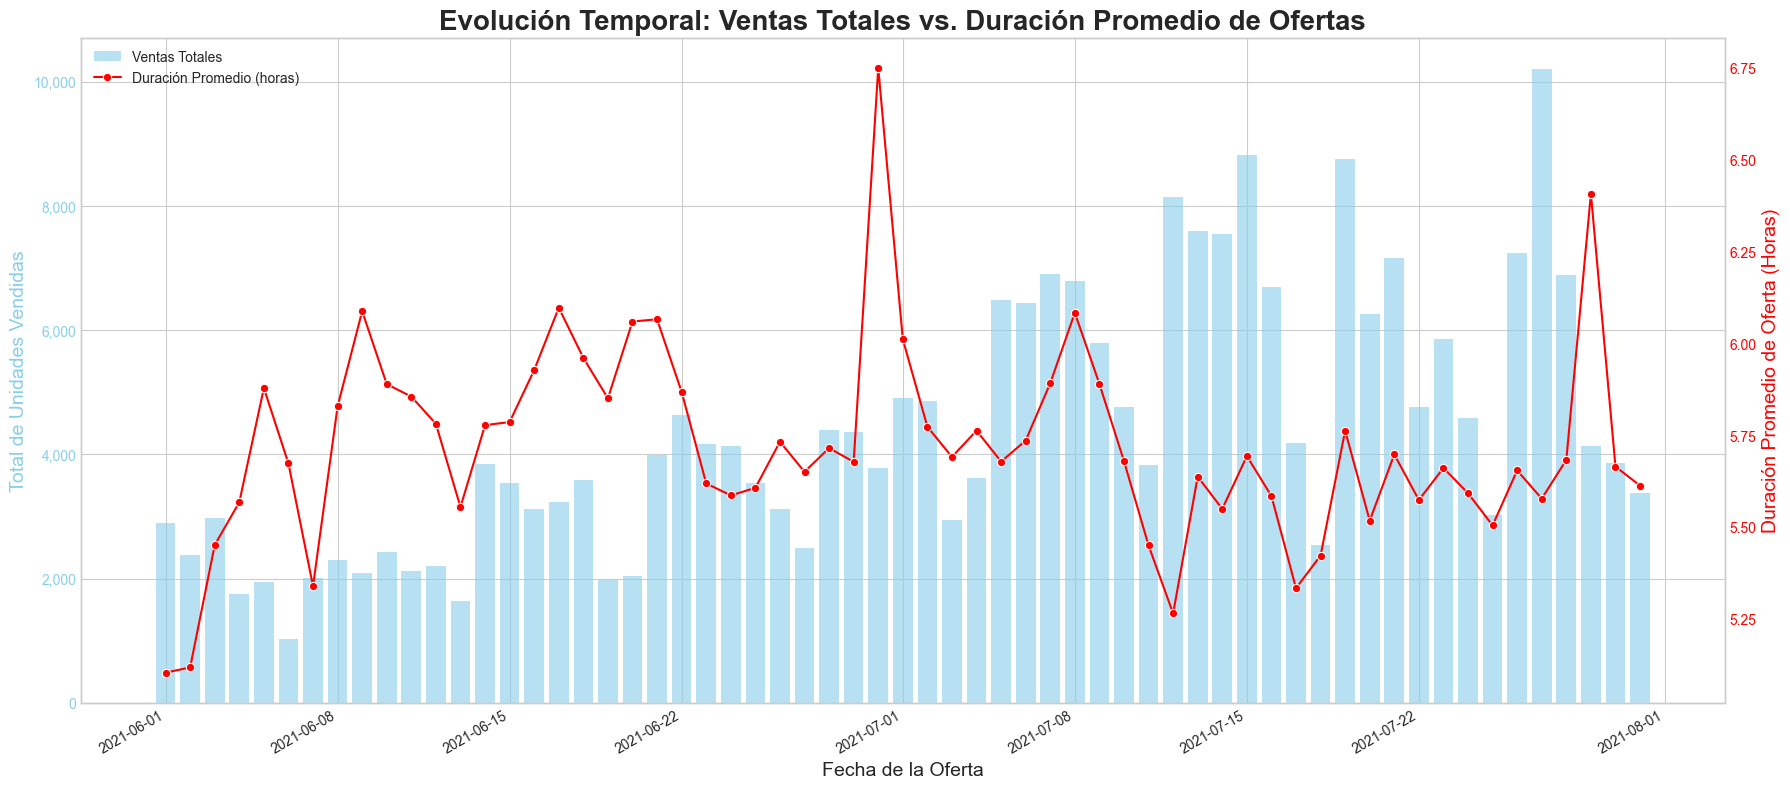

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

# --- Preparación de los Datos Diarios ---
df['offer_date'] = df['OFFER_START_DTTM'].dt.date
daily_trends = df.groupby('offer_date').agg(
    total_sales=('SOLD_QUANTITY', 'sum'),
    avg_duration_hours=('deal_duration_hours', 'mean')
).reset_index()
daily_trends['offer_date'] = pd.to_datetime(daily_trends['offer_date'])

# --- 2. CÁLCULO DE CORRELACIÓN  ---
correlation = daily_trends['total_sales'].corr(daily_trends['avg_duration_hours'])

print("--- Análisis de Correlación ---")
print(f"El coeficiente de correlación entre 'Ventas Totales' y 'Duración Promedio' es: {correlation:.4f}")

# --- Creación del Gráfico de Doble Eje (sin cambios en la lógica) ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax1 = plt.subplots(figsize=(18, 8))

ax2 = ax1.twinx()

# Gráfico de línea para la duración
color_duration = 'red'
sns.lineplot(
    data=daily_trends, 
    x='offer_date', 
    y='avg_duration_hours', 
    color=color_duration, 
    ax=ax2, 
    marker='o', 
    label='Duración Promedio (horas)'
)
ax2.set_ylabel('Duración Promedio de Oferta (Horas)', color=color_duration, fontsize=14)
ax2.tick_params(axis='y', labelcolor=color_duration)
ax2.grid(False)

# Gráfico de barras para las ventas
color_sales = 'skyblue'
ax1.bar(
    daily_trends['offer_date'], 
    daily_trends['total_sales'], 
    color=color_sales, 
    alpha=0.6, 
    label='Ventas Totales',
    width=0.8
)
ax1.set_xlabel('Fecha de la Oferta', fontsize=14)
ax1.set_ylabel('Total de Unidades Vendidas', color=color_sales, fontsize=14)
ax1.tick_params(axis='y', labelcolor=color_sales)
ax1.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))

plt.title('Evolución Temporal: Ventas Totales vs. Duración Promedio de Ofertas', fontsize=20, weight='bold')

ax1.xaxis.set_major_locator(mdates.AutoDateLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
fig.autofmt_xdate()

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

plt.tight_layout()
plt.show()

La anterior gráfica deriva en unn hallazgo interesante, no existe una correlación lineal entre la duración de la oferta y la cantidad de ventas totales entendidas como cantidad de unidades vendidas. Esto es confirmado cuando se hace la correlación entre las dos variables en cuestión: se obtiene una correlación de -0.0630, lo que refleja que no existe relación entre estas dos variables.

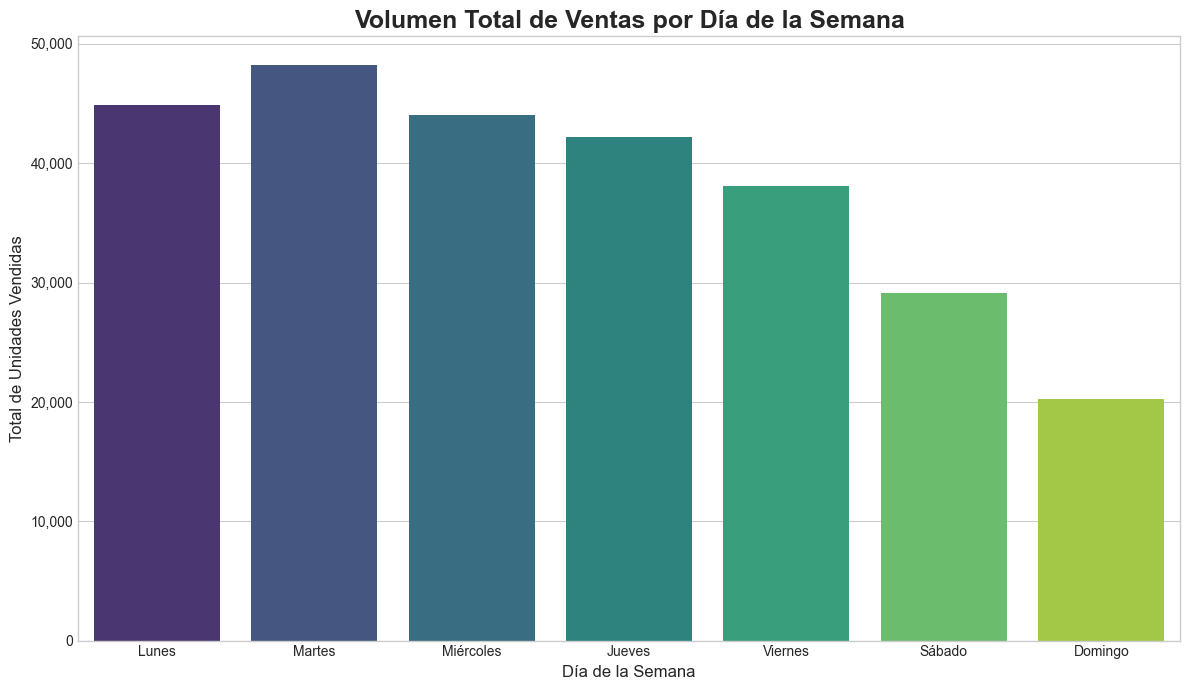

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

daily_sales = df.groupby('day_of_week')['SOLD_QUANTITY'].sum().reset_index()

day_order = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']
daily_sales['day_of_week'] = pd.Categorical(daily_sales['day_of_week'], categories=day_order, ordered=True)
daily_sales = daily_sales.sort_values('day_of_week')

plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 7))

sns.barplot(data=daily_sales, x='day_of_week', y='SOLD_QUANTITY', palette='viridis', ax=ax)

ax.set_title('Volumen Total de Ventas por Día de la Semana', fontsize=18, weight='bold')
ax.set_xlabel('Día de la Semana', fontsize=12)
ax.set_ylabel('Total de Unidades Vendidas', fontsize=12)
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ','))) 

plt.tight_layout()
plt.show()

La anterior gráfica refleja la cantidad de unidades vendidas dentro de las ofertas contra el día de la semana (de forma ponderada). Allí se puede notar que el día con mayor cantidad de ventas ponderadas ocurre el marte, mientras que el día en que menos es el domingo. De lo anterior uno podría pensar que la gentes es más propensa a comprar un martes que un domingo dentro de las ofertas relámpago.

## Análisis de la influencia de la variable "OFFER_TYPE"

--- Análisis de Venta Promedio por Tipo de Envío en Top 15 Categorías ---


SHIPPING_PAYMENT_TYPE,free_shipping,none
DOM_DOMAIN_AGG1,,
PHARMACEUTICS,15.124260,41.631210
BEAUTY EQUIPMENT,2.125201,46.266807
HOME&DECOR,1.734966,3.587600
COMPUTERS,2.313953,4.681044
SPORTS,1.302294,3.144992
APPAREL,1.503132,2.479808
APPAREL ACCESORIES,1.121466,2.180876
MOBILE,3.983687,2.504065
ELECTRONICS,2.146201,1.824934


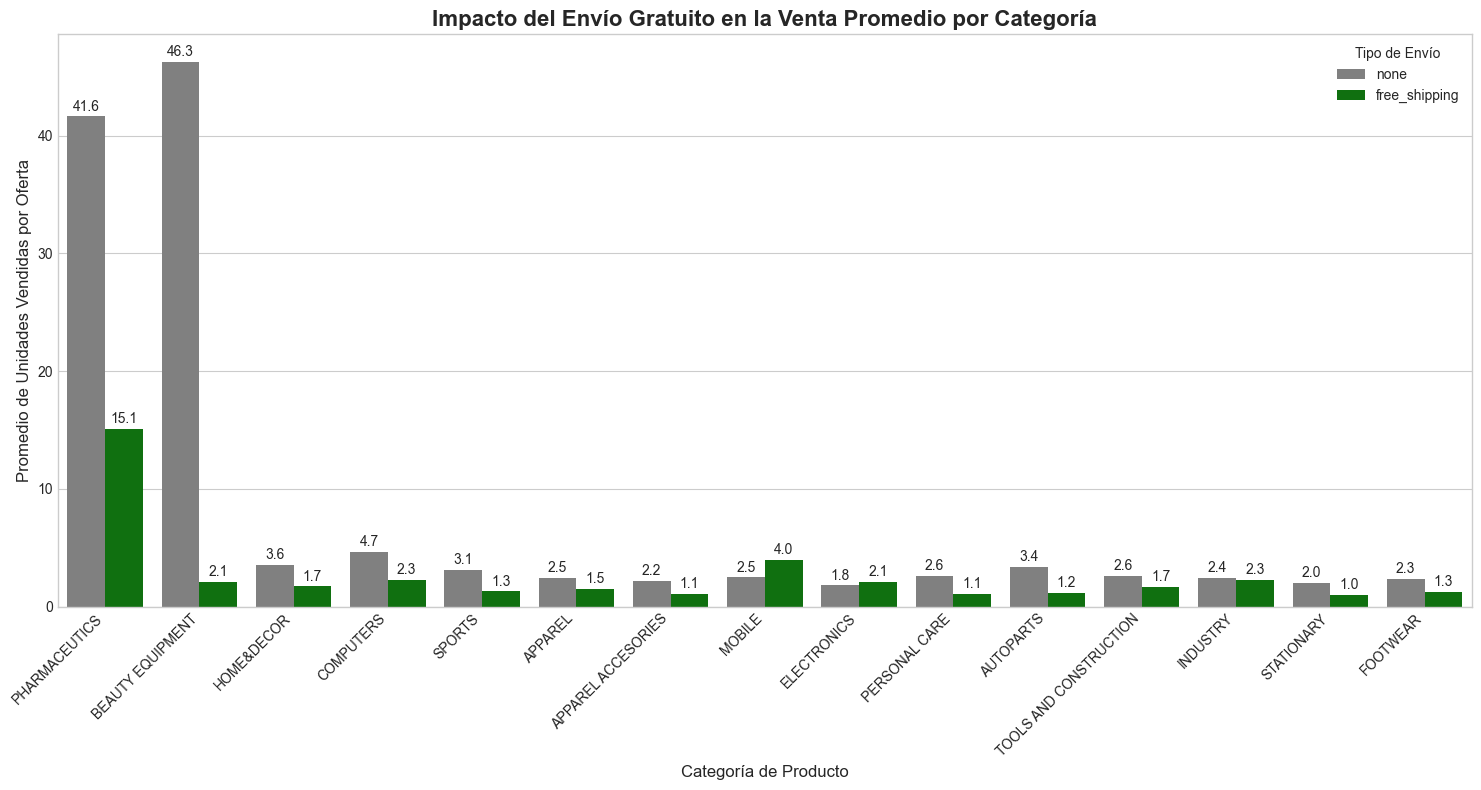

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- Preparación de Datos ---
top_categories_list = df.groupby('DOM_DOMAIN_AGG1')['SOLD_QUANTITY_CALCULATED'].sum().nlargest(15).index

df_top_categories = df[df['DOM_DOMAIN_AGG1'].isin(top_categories_list)]

shipping_impact = df_top_categories.groupby(['DOM_DOMAIN_AGG1', 'SHIPPING_PAYMENT_TYPE']).agg(
    mean_sold_quantity=('SOLD_QUANTITY_CALCULATED', 'mean'),
    offer_count=('OFFER_TYPE', 'count')
).reset_index()

shipping_impact['DOM_DOMAIN_AGG1'] = pd.Categorical(shipping_impact['DOM_DOMAIN_AGG1'], categories=top_categories_list, ordered=True)
shipping_impact = shipping_impact.sort_values('DOM_DOMAIN_AGG1')


# --- Mostrar la Tabla de Datos ---
print("--- Análisis de Venta Promedio por Tipo de Envío en Top 15 Categorías ---")

display(shipping_impact.pivot_table(
    index='DOM_DOMAIN_AGG1', 
    columns='SHIPPING_PAYMENT_TYPE', 
    values='mean_sold_quantity'
).fillna(0))


# --- Creación del Gráfico de Barras Agrupado ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(15, 8))

# Creamos el gráfico con seaborn. 'hue' es el parámetro clave para agrupar las barras.
sns.barplot(
    data=shipping_impact,
    x='DOM_DOMAIN_AGG1',
    y='mean_sold_quantity',
    hue='SHIPPING_PAYMENT_TYPE',
    ax=ax,
    palette={'free_shipping': 'green', 'none': 'grey'}
)

# --- Mejoras Visuales del Gráfico ---
ax.set_title('Impacto del Envío Gratuito en la Venta Promedio por Categoría', fontsize=16, weight='bold')
ax.set_xlabel('Categoría de Producto', fontsize=12)
ax.set_ylabel('Promedio de Unidades Vendidas por Oferta', fontsize=12)
ax.legend(title='Tipo de Envío')

plt.xticks(rotation=45, ha='right')

for container in ax.containers:
    ax.bar_label(container, fmt='%.1f', label_type='edge', padding=2)

plt.tight_layout()
plt.show()


La anterior gráfica refleja que en categorías predominantes (y en general la mayoría de categorías), tener free shipping no parece ser un atractivo definitivo al momento de la compra dentro de las ofertas relámpago 

# Análisis de sobre-ventas
La sobreventa es un fenómeno visible dentro del dataset propuesto. Ocurre que existen REMAINING_STOCK_AFTER_END con valores negativos, lo que sugiere que se vendieron más unidades de las disponibles en STOCK al momento de finalizar la oferta. Lo anterior me hace cuestionar si esto es un fenómeno recurrente dentro de Mercado Libre.

--- Resumen del Fenómeno de Sobreventa ---
Número total de ofertas con sobreventa: 1273
Porcentaje de ofertas con sobreventa sobre el total: 2.61%
Total de unidades vendidas de más (sobreventa): 3817

Estadísticas de las unidades vendidas de más por oferta:


count    1273.000000
mean        2.998429
std         7.151659
min         1.000000
25%         1.000000
50%         1.000000
75%         3.000000
max       192.000000
Name: OVERSOLD_UNITS, dtype: float64



--- Análisis de Sobreventa por Categoría de Producto ---


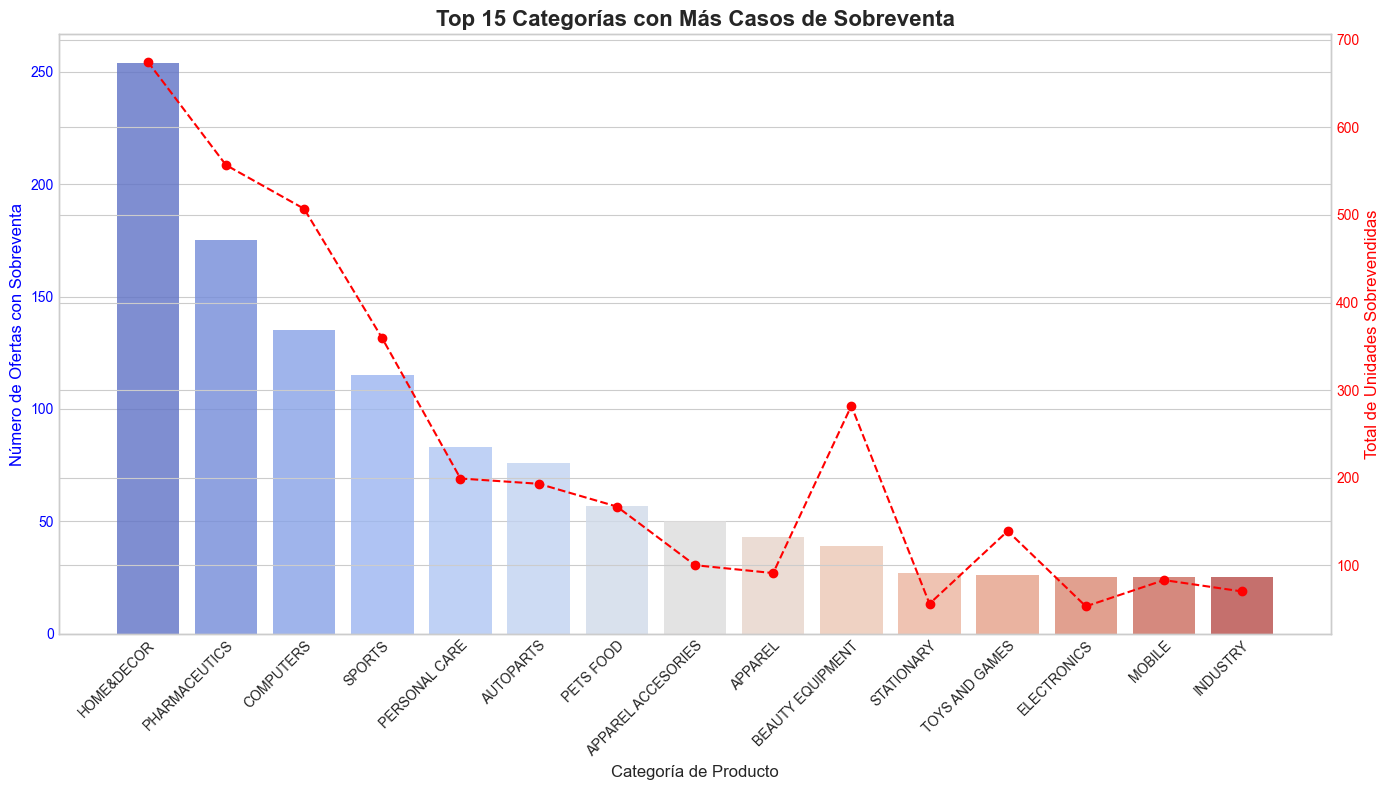

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Identificar y Cuantificar la Sobreventa ---
df['IS_OVERSOLD'] = df['REMAINING_STOCK_AFTER_END'] < 0

# columna que cuantifica EXACTAMENTE cuántas unidades se vendieron de más.
# Si no hubo sobreventa, el valor es 0.
df['OVERSOLD_UNITS'] = 0
df.loc[df['IS_OVERSOLD'], 'OVERSOLD_UNITS'] = -df['REMAINING_STOCK_AFTER_END']

df_oversold = df[df['IS_OVERSOLD']].copy()

# --- Resumen General de la Sobreventa ---
total_oversold_offers = len(df_oversold)
percentage_oversold = (total_oversold_offers / len(df)) * 100
total_oversold_units = df['OVERSOLD_UNITS'].sum()

print("--- Resumen del Fenómeno de Sobreventa ---")
print(f"Número total de ofertas con sobreventa: {total_oversold_offers}")
print(f"Porcentaje de ofertas con sobreventa sobre el total: {percentage_oversold:.2f}%")
print(f"Total de unidades vendidas de más (sobreventa): {total_oversold_units}")
print("\nEstadísticas de las unidades vendidas de más por oferta:")
display(df_oversold['OVERSOLD_UNITS'].describe())


# --- Análisis por Categoría: ¿Dónde ocurre más la sobreventa? ---
print("\n" + "="*50 + "\n")
print("--- Análisis de Sobreventa por Categoría de Producto ---")
oversold_by_category = df_oversold.groupby('DOM_DOMAIN_AGG1').agg(
    oversold_offer_count=('IS_OVERSOLD', 'count'),
    total_oversold_units=('OVERSOLD_UNITS', 'sum')
).sort_values(by='oversold_offer_count', ascending=False).head(15)

fig, ax1 = plt.subplots(figsize=(14, 8))
sns.barplot(x=oversold_by_category.index, y=oversold_by_category['oversold_offer_count'], ax=ax1, palette='coolwarm', alpha=0.8)
ax1.set_title('Top 15 Categorías con Más Casos de Sobreventa', fontsize=16, weight='bold')
ax1.set_xlabel('Categoría de Producto', fontsize=12)
ax1.set_ylabel('Número de Ofertas con Sobreventa', fontsize=12, color='b')
ax1.tick_params(axis='y', labelcolor='b') # Parametros solo para el eje Y

plt.setp(ax1.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

ax2 = ax1.twinx()
ax2.plot(oversold_by_category.index, oversold_by_category['total_oversold_units'], color='r', marker='o', linestyle='--')
ax2.set_ylabel('Total de Unidades Sobrevendidas', fontsize=12, color='r')
ax2.tick_params(axis='y', labelcolor='r')

fig.tight_layout()
plt.show()

En atención a lo identificado, la categoría con mayor cantidad de sobrevenetas es "HOME&DECOR", seguida de "PHARMACEUTICS" y "COMPUTERS".



--- Análisis Temporal de la Sobreventa (por Hora del Día) ---


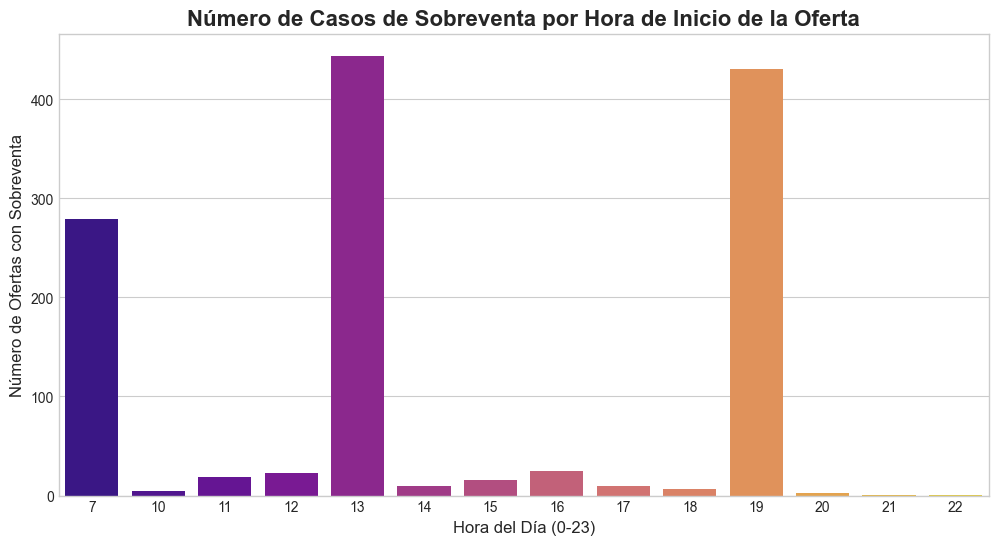

In [79]:


# --- 4. Análisis Temporal: ¿Cuándo ocurre la sobreventa? ---
print("\n" + "="*50 + "\n")
print("--- Análisis Temporal de la Sobreventa (por Hora del Día) ---")
df_oversold['start_hour'] = df_oversold['OFFER_START_DTTM'].dt.hour
oversold_by_hour = df_oversold.groupby('start_hour')['IS_OVERSOLD'].count()

fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x=oversold_by_hour.index, y=oversold_by_hour.values, ax=ax, palette='plasma')
ax.set_title('Número de Casos de Sobreventa por Hora de Inicio de la Oferta', fontsize=16, weight='bold')
ax.set_xlabel('Hora del Día (0-23)', fontsize=12)
ax.set_ylabel('Número de Ofertas con Sobreventa', fontsize=12)
plt.show()

Curiosamente la gran mayoría de ofertas que presentan sobreventas ocurren en unas horas del día muy concretas, 7, 13 y 19. Lo anterior sugiere que en estas horas es que ocurre el inicio simultáneo de la mayoría de ofertas. Nótese que el gráfico anterior solo tiene en cuenta la hora de inicio de la oferta relámpago y no su duración completa. Este análisis ocurrirá en el siguiente gráfico.

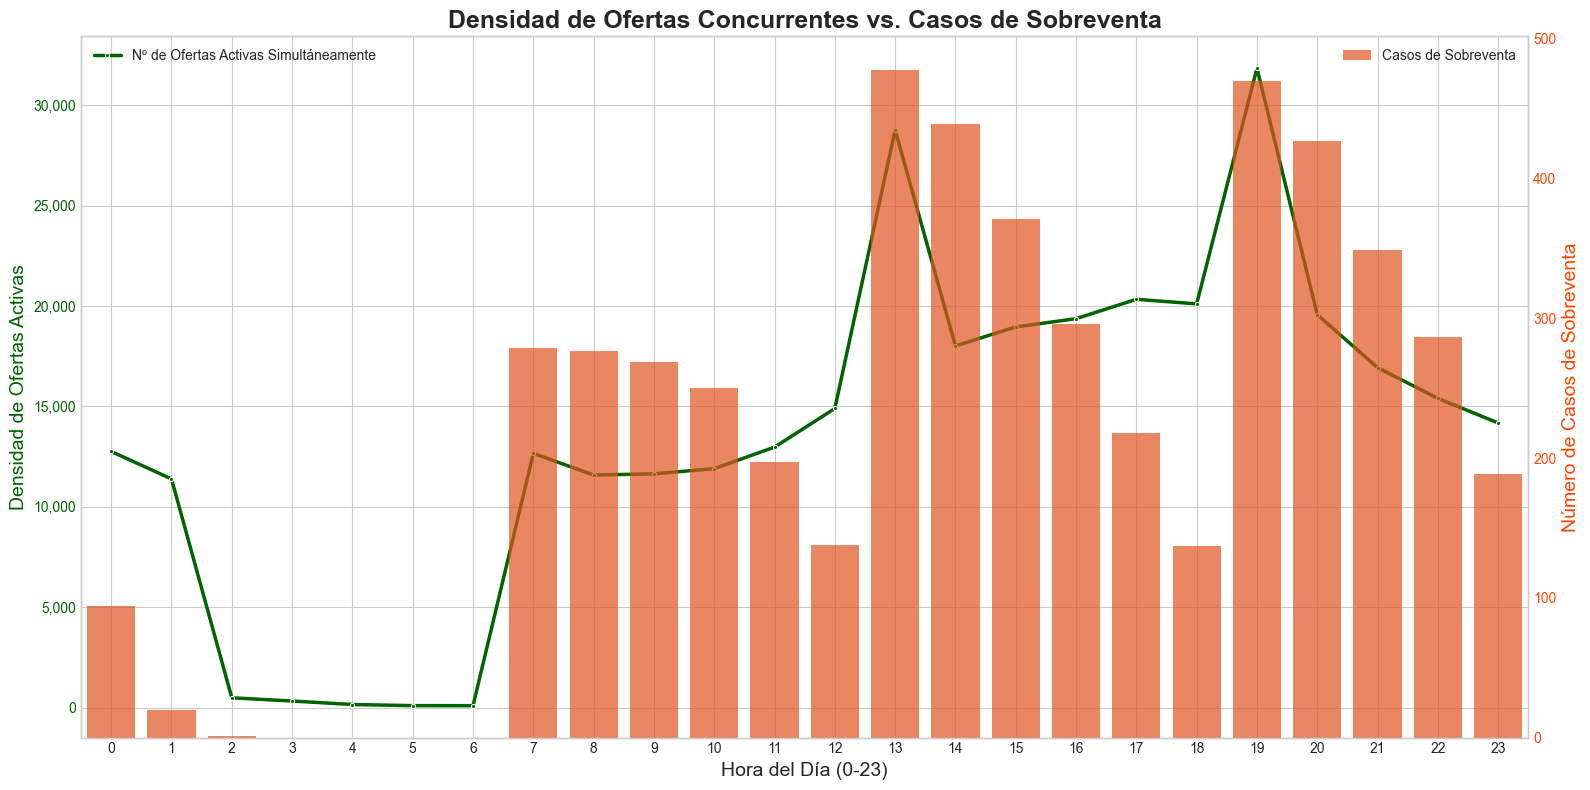

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



hourly_records = []
for _, row in df.iterrows():
    active_hours = pd.date_range(start=row['OFFER_START_DTTM'], end=row['OFFER_FINISH_DTTM'], freq='h')
    for hour_timestamp in active_hours:
        hourly_records.append({
            'hour_of_day': hour_timestamp.hour,
            'is_oversold': row['IS_OVERSOLD']
        })

df_concurrent = pd.DataFrame(hourly_records)


concurrent_offers_by_hour = df_concurrent.groupby('hour_of_day').size().reset_index(name='concurrent_offer_count')

oversold_by_active_hour = df_concurrent[df_concurrent['is_oversold']].groupby('hour_of_day').size().reset_index(name='oversold_count')

concurrent_analysis = pd.merge(concurrent_offers_by_hour, oversold_by_active_hour, on='hour_of_day', how='left').fillna(0)


plt.style.use('seaborn-v0_8-whitegrid')
fig, ax1 = plt.subplots(figsize=(16, 8))

color_total = 'darkgreen'
sns.lineplot(
    data=concurrent_analysis, 
    x='hour_of_day', 
    y='concurrent_offer_count', 
    color=color_total, 
    ax=ax1, 
    marker='.', 
    linewidth=2.5,
    label='Nº de Ofertas Activas Simultáneamente'
)
ax1.set_xlabel('Hora del Día (0-23)', fontsize=14)
ax1.set_ylabel('Densidad de Ofertas Activas', color=color_total, fontsize=14)
ax1.tick_params(axis='y', labelcolor=color_total)
ax1.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))

ax2 = ax1.twinx()

color_oversold = 'orangered'
sns.barplot(
    data=concurrent_analysis,
    x='hour_of_day',
    y='oversold_count',
    ax=ax2,
    color=color_oversold,
    alpha=0.7,
    label='Casos de Sobreventa'
)
ax2.set_ylabel('Número de Casos de Sobreventa', color=color_oversold, fontsize=14)
ax2.tick_params(axis='y', labelcolor=color_oversold)
ax2.grid(False)

plt.title('Densidad de Ofertas Concurrentes vs. Casos de Sobreventa', fontsize=18, weight='bold')
ax1.set_xticks(range(24))
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()


Cada pico de sobreventa está relacionado con la cantidad de ofertas activas, lo cual tiene sentido. La cantidad de casos de sobreventa, o ofertas relámpago que presentaron sobreventa va disminuyendo hasta que vuelve a aumentar la cantidad de ofertas relámpago simultáneas.

# Análsis por producto dentro de las categorías

--- Top 20 Productos por Ingresos Generados ---


,DOMAIN_ID,total_sold_quantity,total_revenue,offer_count,DOM_DOMAIN_AGG1
1094,MLM-SURGICAL_AND_INDUSTRIAL_MASKS,88827,410363.30,1759,PHARMACEUTICS
239,MLM-CELLPHONES,2319,111678.79,219,MOBILE
1131,MLM-TELEVISIONS,688,66366.08,240,ELECTRONICS
369,MLM-DISPOSABLE_GLOVES,13058,55365.39,182,BEAUTY EQUIPMENT
589,MLM-HEADPHONES,4861,29628.06,761,COMPUTERS
1028,MLM-SMARTWATCHES,1593,21572.06,390,MOBILE
1106,MLM-TABLETS,526,19123.19,102,MOBILE
864,MLM-OXIMETERS,8105,17606.61,139,BEAUTY EQUIPMENT
843,MLM-NOTEBOOKS,96,17598.28,194,COMPUTERS
1032,MLM-SNEAKERS,1008,12004.28,453,FOOTWEAR


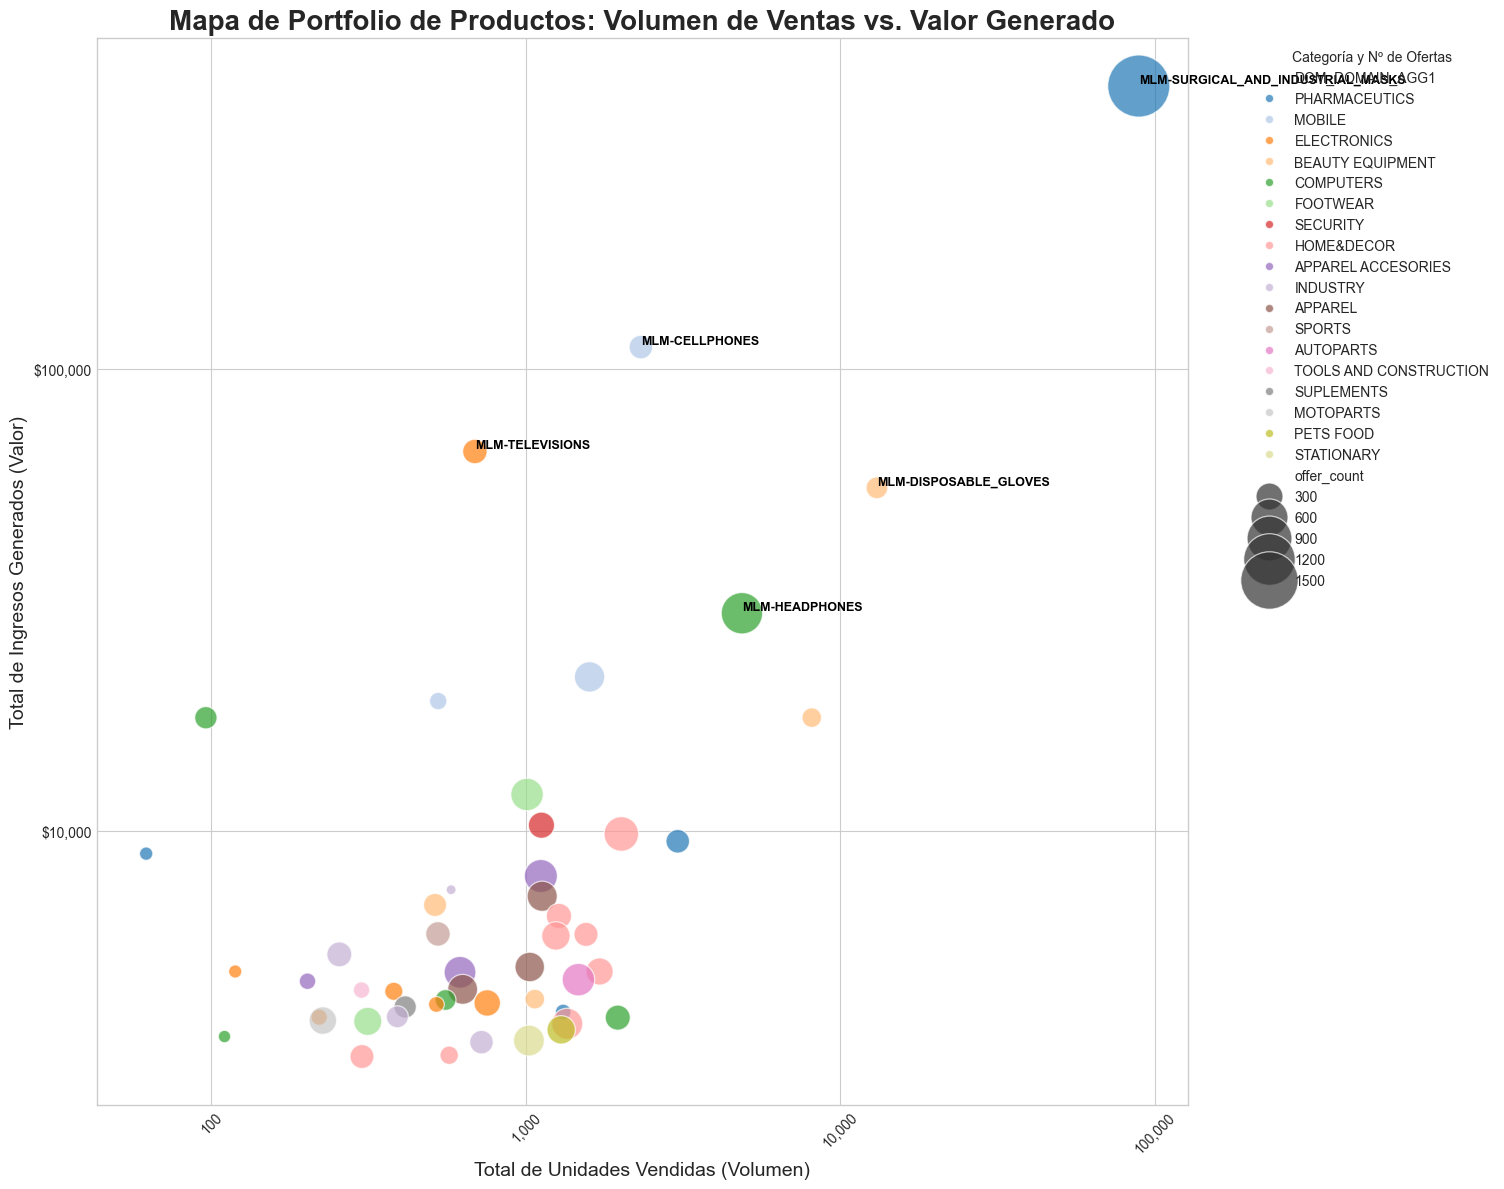

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter, LogLocator

# --- Consolidar Datos de Ventas por Producto (sin cambios) ---
analysis_df = df.groupby('DOMAIN_ID').agg(
    total_sold_quantity=('SOLD_QUANTITY_CALCULATED', 'sum'),
    total_revenue=('SOLD_AMOUNT', 'sum'),
    offer_count=('OFFER_TYPE', 'count')
).reset_index()

domain_category_map = df[['DOMAIN_ID', 'DOM_DOMAIN_AGG1']].drop_duplicates()
analysis_df = pd.merge(analysis_df, domain_category_map, on='DOMAIN_ID', how='left')

analysis_df = analysis_df[analysis_df['total_revenue'] > 0].sort_values(by='total_revenue', ascending=False)


# --- Mostrar la Tabla Consolidada (sin cambios) ---
print("--- Top 20 Productos por Ingresos Generados ---")
display(analysis_df.head(20))


# --- Crear el Gráfico de Dispersión (sin cambios) ---
plot_data = analysis_df.head(50) 
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(18, 12))

scatter = sns.scatterplot(
    data=plot_data,
    x='total_sold_quantity',
    y='total_revenue',
    hue='DOM_DOMAIN_AGG1',
    size='offer_count',
    sizes=(50, 2000),
    alpha=0.7,
    ax=ax,
    palette='tab20'
)

ax.set_title('Mapa de Portfolio de Productos: Volumen de Ventas vs. Valor Generado', fontsize=20, weight='bold')
ax.set_xlabel('Total de Unidades Vendidas (Volumen)', fontsize=14)
ax.set_ylabel('Total de Ingresos Generados (Valor)', fontsize=14)

ax.set_xscale('log')
ax.set_yscale('log')



ax.xaxis.set_major_locator(LogLocator(numticks=15))
ax.yaxis.set_major_locator(LogLocator(numticks=15))

def dollar_formatter(x, pos):
    return f'${int(x):,}'

def number_formatter(x, pos):
    return f'{int(x):,}'

ax.yaxis.set_major_formatter(FuncFormatter(dollar_formatter))
ax.xaxis.set_major_formatter(FuncFormatter(number_formatter))
# ==========================================
    
ax.tick_params(axis='x', rotation=45)
ax.legend(title='Categoría y Nº de Ofertas', bbox_to_anchor=(1.05, 1), loc='upper left')

# Anotar los 5 productos más importantes
for i in range(min(5, len(plot_data))):
    row = plot_data.iloc[i]
    ax.text(row['total_sold_quantity'], row['total_revenue'], row['DOMAIN_ID'], 
            ha='left', va='bottom', fontsize=9, weight='bold', color='black')

plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

Del anterior gráfico, se puede observar, de forma más cualitativa que cuantitativa, que el producto más popular de todos corresponde a "MLM-SURGIAL_AND_INDUSTRUAL_MASK" dentro de la categoría "PHARMACEUTICS", resaltando así nuevamente el contexto acontecido en la pandemia.

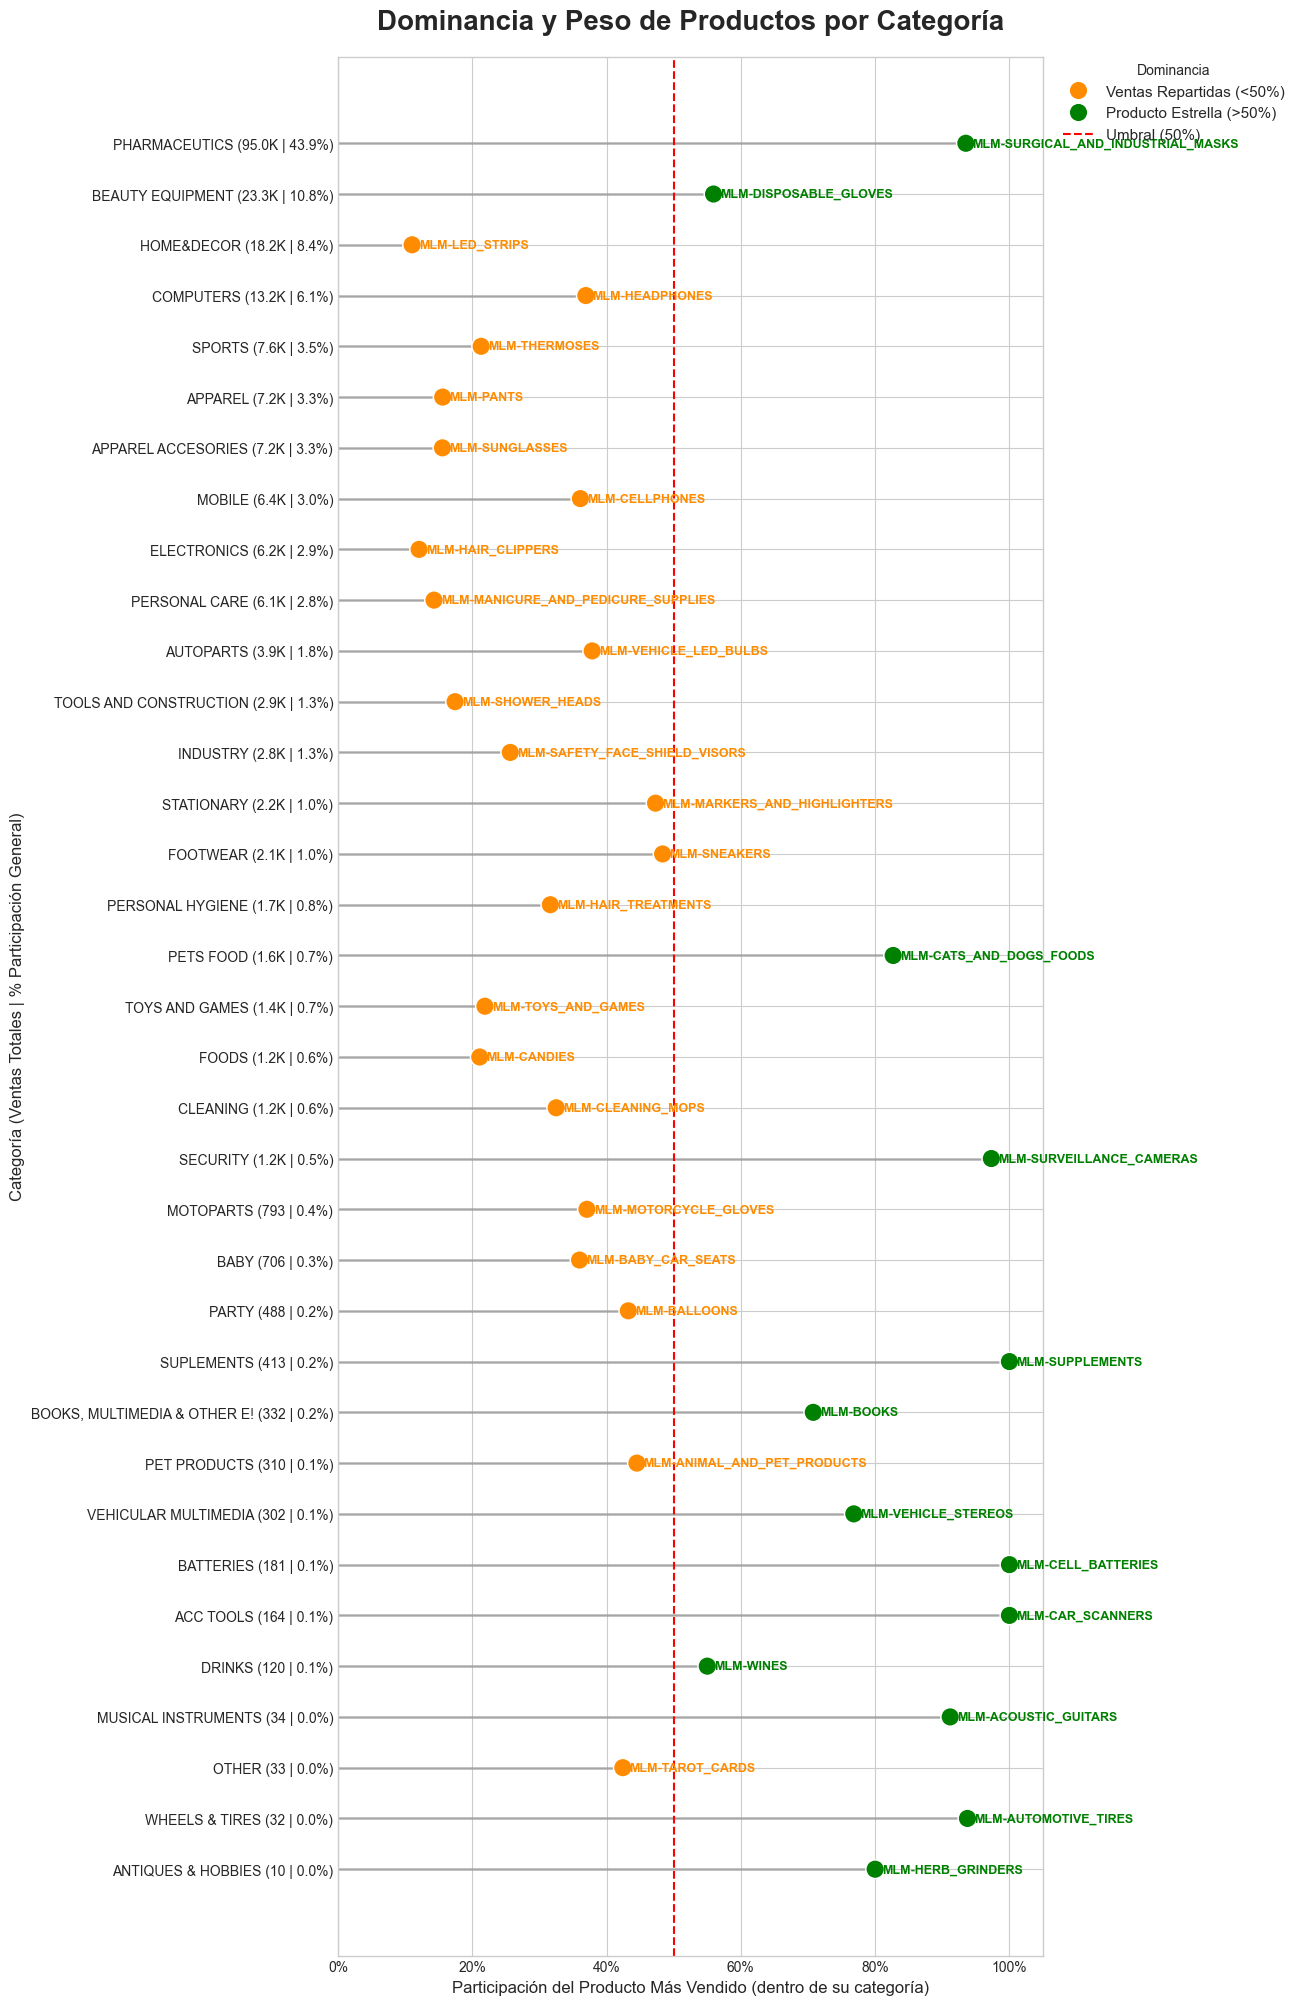

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.collections import PathCollection
from matplotlib.lines import Line2D

# --- Preparación de los Datos ---
product_sales = df.groupby(['DOM_DOMAIN_AGG1', 'DOMAIN_ID'])['SOLD_QUANTITY_CALCULATED'].sum().reset_index()
category_totals = product_sales.groupby('DOM_DOMAIN_AGG1')['SOLD_QUANTITY_CALCULATED'].sum().reset_index().rename(columns={'SOLD_QUANTITY_CALCULATED': 'category_total'})
analysis_data = pd.merge(product_sales, category_totals, on='DOM_DOMAIN_AGG1')
analysis_data['percentage_of_category'] = (analysis_data['SOLD_QUANTITY_CALCULATED'] / analysis_data['category_total']) * 100
safe_analysis_data = analysis_data.dropna(subset=['percentage_of_category'])
dominance_df = safe_analysis_data.loc[safe_analysis_data.groupby('DOM_DOMAIN_AGG1')['percentage_of_category'].idxmax()]


# Calcular el total general de ventas.
grand_total_sales = df['SOLD_QUANTITY_CALCULATED'].sum()
# Calcular el porcentaje de participación de cada categoría sobre el total.
dominance_df['category_participation_pct'] = (dominance_df['category_total'] / grand_total_sales) * 100

dominance_df = dominance_df.sort_values(by='category_total', ascending=False)
dominance_df['has_star_product'] = dominance_df['percentage_of_category'] > 50

def format_sales_label(total_sales):
    if total_sales >= 1_000_000: return f"{total_sales / 1_000_000:.1f}M"
    elif total_sales >= 1_000: return f"{total_sales / 1_000:.1f}K"
    else: return f"{total_sales}"

dominance_df['final_label'] = dominance_df.apply(
    lambda row: f"{row['DOM_DOMAIN_AGG1']} ({format_sales_label(row['category_total'])} | {row['category_participation_pct']:.1f}%)",
    axis=1
)

# --- Creación del Gráfico ---
num_categories = len(dominance_df)
fig_height = max(10, num_categories * 0.6)
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(15, fig_height))

ax.hlines(y=dominance_df['final_label'], xmin=0, xmax=dominance_df['percentage_of_category'], color='grey', alpha=0.5, linewidth=2)
sns.scatterplot(data=dominance_df, y='final_label', x='percentage_of_category', hue='has_star_product', palette={True: 'green', False: 'darkorange'}, s=180, zorder=3)

ax.axvline(x=50, color='red', linestyle='--', linewidth=1.5, label='Umbral de Producto Estrella (50%)')
ax.set_title('Dominancia y Peso de Productos por Categoría', fontsize=20, weight='bold', pad=20)
ax.set_xlabel('Participación del Producto Más Vendido (dentro de su categoría)', fontsize=12)
ax.set_ylabel('Categoría (Ventas Totales | % Participación General)', fontsize=12)
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x)}%'))
ax.set_xlim(0, 105)
ax.tick_params(axis='y', labelsize=10)

for index, row in dominance_df.iterrows():
    color = 'green' if row['has_star_product'] else 'darkorange'
    ax.text(x=row['percentage_of_category'] + 1, y=row['final_label'], s=row['DOMAIN_ID'], color=color, va='center', ha='left', fontsize=9, weight='bold')

handles, labels = ax.get_legend_handles_labels()
new_handles, new_labels = [], []
legend_map = {'Umbral de Producto Estrella (50%)': 'Umbral (50%)', 'True': 'Producto Estrella (>50%)', 'False': 'Ventas Repartidas (<50%)'}
for handle, label in zip(handles, labels):
    original_label_key = label.split(' ')[-1] if isinstance(handle, PathCollection) else label
    if original_label_key in legend_map:
        if isinstance(handle, PathCollection): handle.set_sizes([100])
        new_handles.append(handle); new_labels.append(legend_map[original_label_key])
ax.legend(handles=new_handles, labels=new_labels, title='Dominancia', bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0., fontsize=11)

plt.tight_layout(rect=[0, 0, 0.88, 0.96])
plt.show()


Para identificar si existen "power products" dentro de las distintas categorías —entendidos como aquellos productos que representan más del 50% de las unidades vendidas dentro de su respectiva categoría— se elaboró el gráfico anterior. En este, los productos que superan el umbral del 50% están destacados en verde, mientras que aquellos que no alcanzan dicho porcentaje se muestran en naranja.

# Conclusiones y Hallazgos

## 1. Calidad de Datos

- **Inconsistencia en stock**: Se detectó que el aproximadamente el 7% de las ofertas presentan discrepancias en el cálculo de stock restante, donde la fórmula `INVOLVED_STOCK - SOLD_QUANTITY ≠ REMAINING_STOCK_AFTER_END`.
- **Variable SOLD_AMOUNT**: Se puede intuir que representa una unidad monetaria (ingresos) con una correlación de 0.71 con SOLD_QUANTITY, lo que quiere decir que cuando SOLD_QUANTITY aumenta, SOLD_AMOUNT también lo hace

## 2. Análisis Temporal

- **Duración promedio**: Las ofertas relámpago duran en promedio 5.71 horas, con un rango de 0 a 104.75 horas.
- **Patrón semanal**: Los martes registran el mayor volumen de ventas, mientras que los domingos presentan el menor.
- **No correlación duración-ventas**: No existe una correlación entre la duración de la oferta y las ventas totales, lo que sugiere que la duración de la oferta relámpago realmente no influye en la cantidad de unidades vendidas.

## 3. Rendimiento por Categorías

- **Dominancia de PHARMACEUTICS**: Esta categoría representa el 43.3% de las unidades vendidas y el 35.0% del revenue total.
- **Contexto pandémico**: Los datos parecen reflejar el impacto de la pandemia, con productos farmacéuticos y mascarillas quirúrgicas dominando las ventas, tanto en cantidad como revenue.
- **Ticket promedio**: "Wheels & Tires" tiene el mayor ticket promedio, mientras que "Drinks" y "Personal Care" tienen los menores.

## 4. Fenómeno de Sobreventa

- **Prevalencia**: El dataset muestra casos de sobreventa donde `REMAINING_STOCK_AFTER_END < 0`.
- **Categorías afectadas**: "HOME & DECOR" lidera en número de casos de sobreventa, seguida por "PHARMACEUTICS".
- **Patrón horario**: Las sobreventas se concentran en horas específicas (7, 13 y 19), coincidiendo con picos de ofertas simultáneas.

- **Pregunta**: ¿De ser un fenómeno real, ¿cómo se suele manjar?

## 5. Análisis de Productos

- **Producto estrella**: "MLM-SURGICAL_AND_INDUSTRIAL_MASK" es el producto individual más vendido.
- **Concentración por categoría**: Varias categorías tienen "power products" que representan >50% de sus ventas totales.
- **Envío gratuito**: No se observa un impacto significativo del free shipping en el volumen de ventas promedio, incluso llega a ser menor que la forma estándar de envío, sin una influencia clara.

## 6. Insights de Negocio

- Las ofertas relámpago fueron especialmente efectivas durante el contexto pandémico para productos de salud teniendo en cuenta únicamente los datos proporcionados.
- La sobreventa podría indicar alta demanda o problemas en la gestión de inventario en tiempo real, lo que sugiere un análisis más profundo sobre el fenómeno.
- Los patrones temporales sugieren momentos óptimos para lanzar ofertas (martes, horas pico).
- La concentración de ventas en pocos productos por categoría indica oportunidades de diversificación en la oferta dentro de las categorías.